<a href="https://colab.research.google.com/github/zec1616/cyngua/blob/main/problem_set_2_Q1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 1a

!pip install bitarray
from bitarray import bitarray
from hashlib import sha3_256, sha256, blake2b

class BloomFilter:
    def __init__(self, size):
        # Initialize the Bloom filter with a given size
        self.size = size
        # Create a bitarray of the specified size, initially all set to 0
        self.bit_array = bitarray(size)
        self.bit_array.setall(0)

    # Hash function 1: SHA256
    def _hash1(self, item):
        return int(sha256(item.lower().encode()).hexdigest(), 16) % self.size

    # Hash function 2: BLAKE2b
    def _hash2(self, item):
        return int(blake2b(item.lower().encode()).hexdigest(), 16) % self.size

    # Hash function 3: SHA3-256
    def _hash3(self, item):
        return int(sha3_256(item.lower().encode()).hexdigest(), 16) % self.size

    def add(self, item):
        # Set bits at positions determined by all three hash functions
        self.bit_array[self._hash1(item)] = 1
        self.bit_array[self._hash2(item)] = 1
        self.bit_array[self._hash3(item)] = 1

    def check(self, item):
        # Check if an item might be in the set
        # Returns True if all bits are set, False otherwise
        return (self.bit_array[self._hash1(item)] and
                self.bit_array[self._hash2(item)] and
                self.bit_array[self._hash3(item)])

def populate_bloom_filter(bloom_filter, word_file):
    # Open the file containing words
    with open('sample_data/words.txt') as f:
        # Read the file line by line
        for line in f:
            # Strip whitespace and newline characters
            word = line.strip()
            # Add each word to the Bloom filter
            bloom_filter.add(word)

# Choose the size, larger size reduces false positives but uses more memory
size = 10000000
# Create a new Bloom filter instance
bf = BloomFilter(size)
# Populate the Bloom filter with words from 'words.txt'
populate_bloom_filter(bf, 'words.txt')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.4/288.4 kB 8.9 MB/s eta 0:00:00


In [ ]:
# 1b - Implement a Spelling Correction Function

import string

def spell_check_and_correct(word, bloom_filter):
    # First, check if the word is in the Bloom filter
    matched = bloom_filter.check(word)
    if matched:
        # If the word is matched, return True and the word itself
        return True, [word]

    possible_corrections = []
    # Get all lowercase letters to use for substitutions
    alphabet = string.ascii_lowercase

    # Iterate through each character in the word
    for i in range(len(word)):
        # Try substituting each letter of the alphabet
        for char in alphabet:
            # Create a new word by replacing the i-th character
            new_word = word[:i] + char + word[i+1:]
            # Check if the new word is in the Bloom filter
            # and ensure it's not the same as the original word
            if bloom_filter.check(new_word) and new_word != word:
                possible_corrections.append(new_word)

    # Return False (not matched) and the list of possible corrections
    return False, possible_corrections

# List of words to check, including English and non-English words
words_to_check = [
    "hello",    # Common English word
    "hi",       # Short English word
    "world",    # Another common English word
    "helo",     # Misspelling of "hello"
    "hl",       # Not a word, but could be a typo
    "world",    # Duplicate of earlier word
    "worlt",    # Misspelling of "world"
    "hello professor"
]

# Check each word and print results
for word in words_to_check:
    # Get match status and corrections for the current word
    matched, corrections = spell_check_and_correct(word, bf)

    # Print whether the word is matched in the Bloom filter
    if matched:
        print(f"'{word}' is matched in the Bloom filter.")
    else:
        print(f"'{word}' is not matched in the Bloom filter.")

    # If not matched, print possible corrections or "No corrections found"
    if not matched and corrections:
        print(f"  Possible corrections: {corrections}")
    elif not matched and not corrections:
        print("  No corrections found.")

    print()  # Add a blank line for readability between words

'hello' is matched in the Bloom filter.

'hi' is matched in the Bloom filter.

'world' is matched in the Bloom filter.

'helo' is not matched in the Bloom filter.
  Possible corrections: ['velo', 'halo', 'hilo', 'heao', 'hebo', 'heho', 'hero', 'hela', 'held', 'hele', 'heli', 'hell', 'helm', 'help']

'hl' is matched in the Bloom filter.

'world' is matched in the Bloom filter.

'worlt' is not matched in the Bloom filter.
  Possible corrections: ['worst', 'world']

'hello professor' is not matched in the Bloom filter.
  No corrections found.



In [ ]:
# 1b - Performance Measure

import json

def evaluate_performance(bloom_filter, typos_file):
    # Load the typos data from a JSON file
    with open('sample_data/typos.json', 'r') as f:
        typos = json.load(f)

    # Initialize counters
    total_pairs = len(typos)
    good_suggestions = 0
    false_positives = 0

    # Iterate through each word pair in the typos data
    for typed_word, correct_word in typos:
        # Use the spell check function to get results
        matched, suggestions = spell_check_and_correct(typed_word, bloom_filter)

        # Case 1: Correctly identified a correctly spelled word
        if matched and typed_word == correct_word:
            good_suggestions += 1
        # Case 2: Word not in bloom filter, check suggestions
        elif not matched:
            # Good suggestion if correct word is in top 3 suggestions
            if len(suggestions) <= 3 and correct_word in suggestions:
                good_suggestions += 1

            # Count false positives for actual typos
            if typed_word != correct_word:
                false_positives += len([word for word in suggestions if word != correct_word])

    # Calculate rates
    good_suggestion_rate = good_suggestions / total_pairs
    false_positive_rate = false_positives / sum(1 for _, correct in typos if _ != correct)

    return good_suggestion_rate, false_positive_rate

# Usage example
typos_file = 'typos.json'
good_suggestion_rate, false_positive_rate = evaluate_performance(bf, typos_file)

# Print the good suggestion rate as a percentage
print(f"Good Suggestion Rate: {good_suggestion_rate:.2%}")

Good Suggestion Rate: 95.80%


In [ ]:
pip install numpy matplotlib bitarray mmh3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.2/93.2 kB 2.8 MB/s eta 0:00:00


Analyzing configurations: 100%|██████████| 27/27 [02:42<00:00,  6.00s/it]


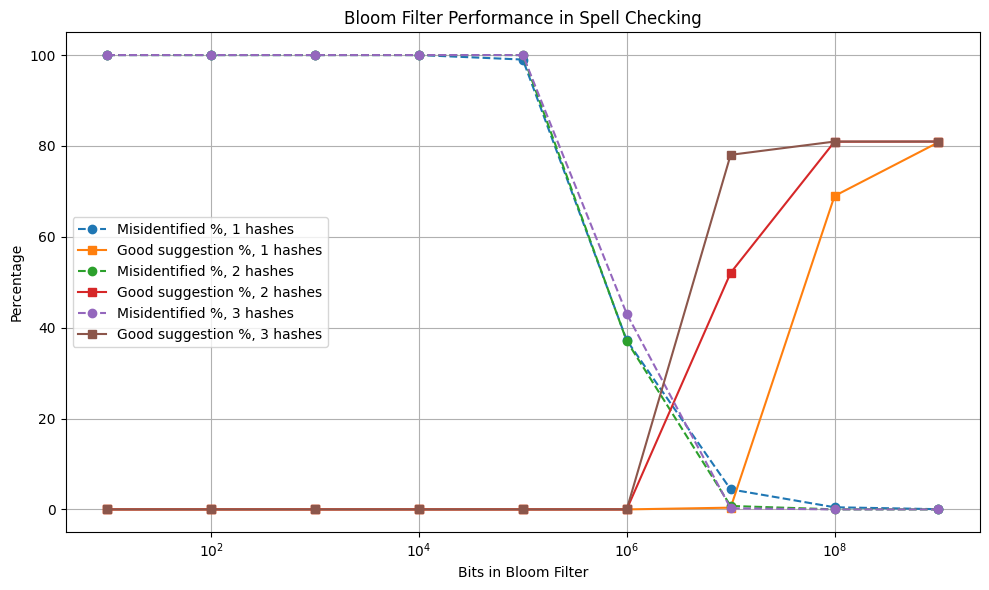


Maximum good suggestion percentages achieved:
For 1 hash function(s):
  Max good suggestions: 80.80% with 1000000000 bits
For 2 hash function(s):
  Max good suggestions: 80.96% with 1000000000 bits
For 3 hash function(s):
  Max good suggestions: 80.96% with 100000000 bits

Results for 85% good suggestions target:
85% good suggestions not achieved for 1 hash function(s) within tested range
  Highest achieved: 80.80% with 1000000000 bits
85% good suggestions not achieved for 2 hash function(s) within tested range
  Highest achieved: 80.96% with 1000000000 bits
85% good suggestions not achieved for 3 hash function(s) within tested range
  Highest achieved: 80.96% with 100000000 bits


In [ ]:
# 1c

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from bitarray import bitarray

class BloomFilter:
    # Bloom Filter for set membership testing
    def __init__(self, size, k):
        # Initialize filter with size and number of hash functions
        self.size = size
        self.bit_array = bitarray(size)
        self.bit_array.setall(0)
        self.k = k
        self.hash_functions = [self._hash1, self._hash2, self._hash3][:k]

    def _hash1(self, item):
        # First hash function
        return hash(item + "salt1") % self.size

    def _hash2(self, item):
        # Second hash function
        return hash(item + "salt2") % self.size

    def _hash3(self, item):
        # Third hash function
        return hash(item + "salt3") % self.size

    def add(self, item):
        # Add item to Bloom filter
        for hash_function in self.hash_functions:
            self.bit_array[hash_function(item)] = 1

    def check(self, item):
        # Check if item is in Bloom filter
        return all(self.bit_array[hash_function(item)] for hash_function in self.hash_functions)

def populate_bloom_filter(bf, word_file):
    # Populate Bloom filter with words from file
    with open(word_file, 'r') as f:
        for line in f:
            bf.add(line.strip())

def spell_check_and_correct(word, bloom_filter):
    # Check word and suggest corrections if needed
    if bloom_filter.check(word):
        return True, [word]

    suggestions = []
    for i in range(len(word)):
        for c in string.ascii_lowercase:
            new_word = word[:i] + c + word[i+1:]
            if bloom_filter.check(new_word) and new_word != word:
                suggestions.append(new_word)
    return False, suggestions

def evaluate_performance(bloom_filter, typos_file):
    # Evaluate Bloom filter performance on typos dataset
    with open(typos_file, 'r') as f:
        typos = json.load(f)

    total_pairs = len(typos)
    wrong_spell = 0.5 * total_pairs
    good_suggestions = 0
    misidentified = 0

    for typed_word, correct_word in typos:
        matched, suggestions = spell_check_and_correct(typed_word, bloom_filter)

        if matched and typed_word != correct_word:
            misidentified += 1
        elif not matched and len(suggestions) <= 3 and correct_word in suggestions:
            good_suggestions += 1

    return (good_suggestions / wrong_spell * 100, misidentified / wrong_spell * 100)

def analyze_configurations(sizes, hash_functions, word_file, typos_file):
    # Analyze different Bloom filter configurations
    results = []
    total_iterations = len(sizes) * len(hash_functions)

    with tqdm(total=total_iterations, desc="Analyzing configurations") as pbar:
        for size in sizes:
            for k in hash_functions:
                bf = BloomFilter(size, k)
                populate_bloom_filter(bf, word_file)
                results.append((size, k, *evaluate_performance(bf, typos_file)))
                pbar.update(1)

    return results

def plot_results(results):
    # Plot Bloom filter performance results
    sizes = sorted(set(r[0] for r in results))
    hash_functions = sorted(set(r[1] for r in results))

    plt.figure(figsize=(10, 6))

    for k in hash_functions:
        good_suggestions = [r[2] for r in results if r[1] == k]
        misidentified = [r[3] for r in results if r[1] == k]

        plt.plot(sizes, misidentified, marker='o', linestyle='--', label=f'Misidentified %, {k} hashes')
        plt.plot(sizes, good_suggestions, marker='s', label=f'Good suggestion %, {k} hashes')

    plt.xscale('log')
    plt.xlabel('Bits in Bloom Filter')
    plt.ylabel('Percentage')
    plt.title('Bloom Filter Performance in Spell Checking')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def find_max_good_suggestions(results, k):
    # Find maximum good suggestion percentage for given hash function count
    k_results = [r for r in results if r[1] == k]
    max_result = max(k_results, key=lambda x: x[2])
    return max_result

# Main execution
if __name__ == "__main__":
    # Set up parameters
    word_file = 'sample_data/words.txt'
    typos_file = 'sample_data/typos.json'
    sizes = [10**i for i in range(1, 10)]  # 10^1 to 10^9 bits
    hash_functions = [1, 2, 3]

    # Analyze and plot results
    results = analyze_configurations(sizes, hash_functions, word_file, typos_file)
    plot_results(results)

    # Print maximum good suggestion percentages
    print("\nMaximum good suggestion percentages achieved:")
    for k in hash_functions:
        max_result = find_max_good_suggestions(results, k)
        size, _, good_suggestion_rate, _ = max_result
        print(f"For {k} hash function(s):")
        print(f"  Max good suggestions: {good_suggestion_rate:.2f}% with {size} bits")

    # Print results for 85% good suggestions target
    print("\nResults for 85% good suggestions target:")
    for k in hash_functions:
        for size, num_hash, good_suggestion_rate, _ in results:
            if num_hash == k and good_suggestion_rate >= 85:
                print(f"Minimum bits for {k} hash function(s) to achieve 85% good suggestions: {size}")
                break
        else:
            print(f"85% good suggestions not achieved for {k} hash function(s) within tested range")
            max_result = find_max_good_suggestions(results, k)
            size, _, max_rate, _ = max_result
            print(f"  Highest achieved: {max_rate:.2f}% with {size} bits")

As the number of bits in the Bloom filter increases, the percentage of misidentified words (false positives) decreases, while the percentage of good suggestions increases for all hash function combinations.

All combinations show a significant performance improvement around 10^6 bits, with the most significantly change occurring between 10^5 and 10^7 bits

Although my test does not achieve 85%, I believe using over several billions of bits is possible for using 2 or 3 hash functions.